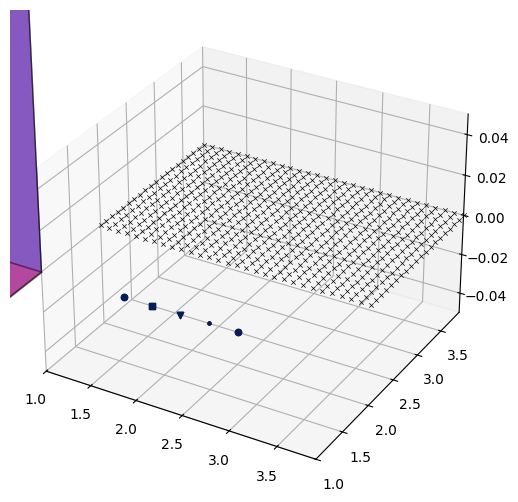

In [2]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Setup Anechoic Room to neglect room effects and simplify
fs = 16000                          # Sampling freq.
room = pra.AnechoicRoom(fs=fs)      # Makes sure no echoing

# Speaker Setup: A 5-speaker linear array | Pyroomacoustics uses 3D coordinates, so we set Z=0
num_speakers = 5                                # 5 speakers
speaker_spacing = 0.15                          # OBS Never used
speaker_x = np.linspace(1.9, 3.1, num_speakers) # 5 evenly places speakers between 1.9 and 3.1 (inclusive)
speaker_locs = np.vstack((speaker_x,                    # x-coord
                          np.full(num_speakers, 1.0),   # y-coord (all the same)
                          np.zeros(num_speakers)))      # z-coord (zeros)

# Every speaker is added as a sound source
for loc in speaker_locs.T:
    room.add_source(loc)

# Microphone Grid
spacing = 0.1                                   # The spacing of the 2D-grid of microphones
x_coords = np.arange(1.0, 4.0, spacing)         
y_coords = np.arange(2.0, 4.0, spacing)
X, Y = np.meshgrid(x_coords, y_coords)          # Mesh-grid
mics_locs = np.vstack((X.flatten(), Y.flatten(), np.zeros(X.size))) # (x,y,z) for all microphones
mic_array = pra.MicrophoneArray(mics_locs, room.fs)
room.add_microphone_array(mic_array)            # Add the microphones to the room

# Plotting
room.plot()

In [3]:
# Calculate H for a given frequency
target_freq = 1000.0
c = pra.constants.get('c')              # Speed of sound
k = 2 * np.pi * target_freq / c

num_mics = mics_locs.shape[1]           # The number of mics (defined in last section)
H = np.zeros((num_mics, num_speakers), dtype=complex) # complex matrix (M * L)

# Populate H
for m in range(num_mics):
    for s in range(num_speakers):
        dist = np.linalg.norm(mics_locs[:, m] - speaker_locs[:, s]) # mics_locs[:, m] = [x y z]
        # Free-field Green's function: (1 / r) * e^(-j * k * r)
        H[m, s] = (1.0 / dist) * np.exp(-1j * k * dist)

# Define Bright and Dark Zones by left/right side of the room
bright_indices = np.where(mics_locs[0, :] < 2.5)[0]     # The idx of the microphones in the bright zone
dark_indices = np.where(mics_locs[0, :] >= 2.5)[0]      # Idx of the microphones in the dark zone

Hb = H[bright_indices, :]   # The whole rows for the microphones in the bright zone
Hd = H[dark_indices, :]     # The whole rows for the microphones in the dark zone

# The ACC Math 
lambda_reg = 1e-4 # Regularization to limit "array effort"
R_dark = Hd.conj().T @ Hd + lambda_reg * np.eye(num_speakers)
R_bright = Hb.conj().T @ Hb

# Find the eigenvectors, optimal weights are the eigenvector corresponding to the largest eigenvalue
vals, vecs = eig(R_bright, R_dark)
optimal_g = vecs[:, np.argmax(np.real(vals))]

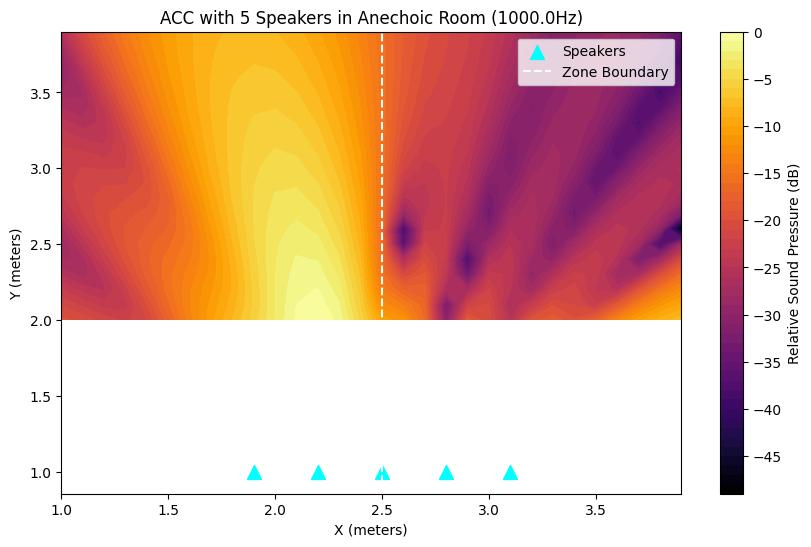

In [4]:
# Multiply the transfer functions by our optimal speaker weights
p = H @ optimal_g
pressure_map = np.abs(p).reshape(X.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, 20 * np.log10(pressure_map / np.max(pressure_map)), levels=50, cmap='inferno')
plt.colorbar(label="Relative Sound Pressure (dB)")

# Overlay speakers and the zone boundary
plt.scatter(speaker_locs[0, :], speaker_locs[1, :], color='cyan', label='Speakers', marker='^', s=100)
plt.axvline(2.5, color='white', linestyle='--', label='Zone Boundary')

plt.title(f"ACC with 5 Speakers in Anechoic Room ({target_freq}Hz)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.show()